In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from src.utils import Data

In [11]:
# file = "data/combinedDataRev3Labeled.csv"
file = "data/combinedDataRev4SlimLabeled.csv"


### create dataframe
DataObj = Data(file)
df = DataObj.ImportData()

### define input (X) and output (y) data
Vc_colnames = ["vc1","vc2","vc3","vc4","vc5","vc6","vc7","vc8"]
X_colnames = ["g1upper","g2upper","g3upper", "g4upper","g5upper","g6upper","g7upper","g8upper","i1","i2"]
y_colnames = ["vout"]
X = np.array(df[X_colnames])[:10000,:]
Vc_all = np.array(df[Vc_colnames])[:10000,:]
y = np.array(df[y_colnames])[1:10001,:]

In [12]:
def f(X_est, X_true):
    """
    state transition MMC dynamics
    """       
    alpha = 1e-5

    C1 = 0.0014 #1e6
    C2 = 0.0014 #1e6
    C3 = 0.0014 #1e6
    C4 = 0.0014 #1e6
    C5 = 0.0014 #1e6
    C6 = 0.0014 #1e6
    C7 = 0.0014 #1e6
    C8 = 0.0014 #1e6
    
    # currents
    i_1 = X_true[-2].reshape(-1,1)
    i_2 = X_true[-1].reshape(-1,1)

    # switching (upper arm)
    S_1 = X_true[0].reshape(-1,1)
    S_2 = X_true[1].reshape(-1,1)
    S_3 = X_true[2].reshape(-1,1)
    S_4 = X_true[3].reshape(-1,1)

    # switching (lower arm)
    S_5 = X_true[4].reshape(-1,1)
    S_6 = X_true[5].reshape(-1,1)
    S_7 = X_true[6].reshape(-1,1)
    S_8 = X_true[7].reshape(-1,1)

    # current capacitence voltage
    Vc_k = X_est

    B = np.diag([1/C1, 1/C2, 1/C3, 1/C4, 1/C5, 1/C6, 1/C7, 1/C8])

    u = np.vstack((
        -1*i_1*S_1,
        -1*i_1*S_2,
        -1*i_1*S_3,
        -1*i_1*S_4,
        -1*i_2*S_5,
        -1*i_2*S_6,
        -1*i_2*S_7,
        -1*i_2*S_8))
    
    Vc_k_1 = Vc_k + alpha * np.dot(B, u)

    return Vc_k_1

In [13]:
def g(Vc_k_1, X_true):
    """
    MMC output dynamics
    """
    V_OP = 1000
    V_ON = 1000

    # switching (upper arm)
    S_1 = X_true[0].reshape(-1,1)
    S_2 = X_true[1].reshape(-1,1)
    S_3 = X_true[2].reshape(-1,1)
    S_4 = X_true[3].reshape(-1,1)

    # switching (lower arm)
    S_5 = X_true[4].reshape(-1,1)
    S_6 = X_true[5].reshape(-1,1)
    S_7 = X_true[6].reshape(-1,1)
    S_8 = X_true[7].reshape(-1,1)

    S_1_4 = np.vstack((S_1, S_2, S_3, S_4))
    S_5_8 = np.vstack((S_5, S_6, S_7, S_8))

    const = (V_OP - V_ON)/2
    upper_arm = (1/2)*np.dot(np.transpose(Vc_k_1[:4, :]), S_1_4)
    lower_arm = (1/2)*np.dot(np.transpose(Vc_k_1[4:, :]), S_5_8)
    V_th = const - upper_arm + lower_arm

    return V_th

In [14]:
Vc = np.array(df[Vc_colnames])[0,:].reshape(-1,1)

Vc_synthetic = [copy.deepcopy(Vc)]
Vth_synthetic = []
for x in X:
    Vc = f(Vc, x)
    Vc_synthetic.append(Vc)

    Vth = g(Vc, x)
    Vth_synthetic.append(Vth)

In [15]:
Vc_synthetic = np.array(Vc_synthetic).reshape(-1,8)

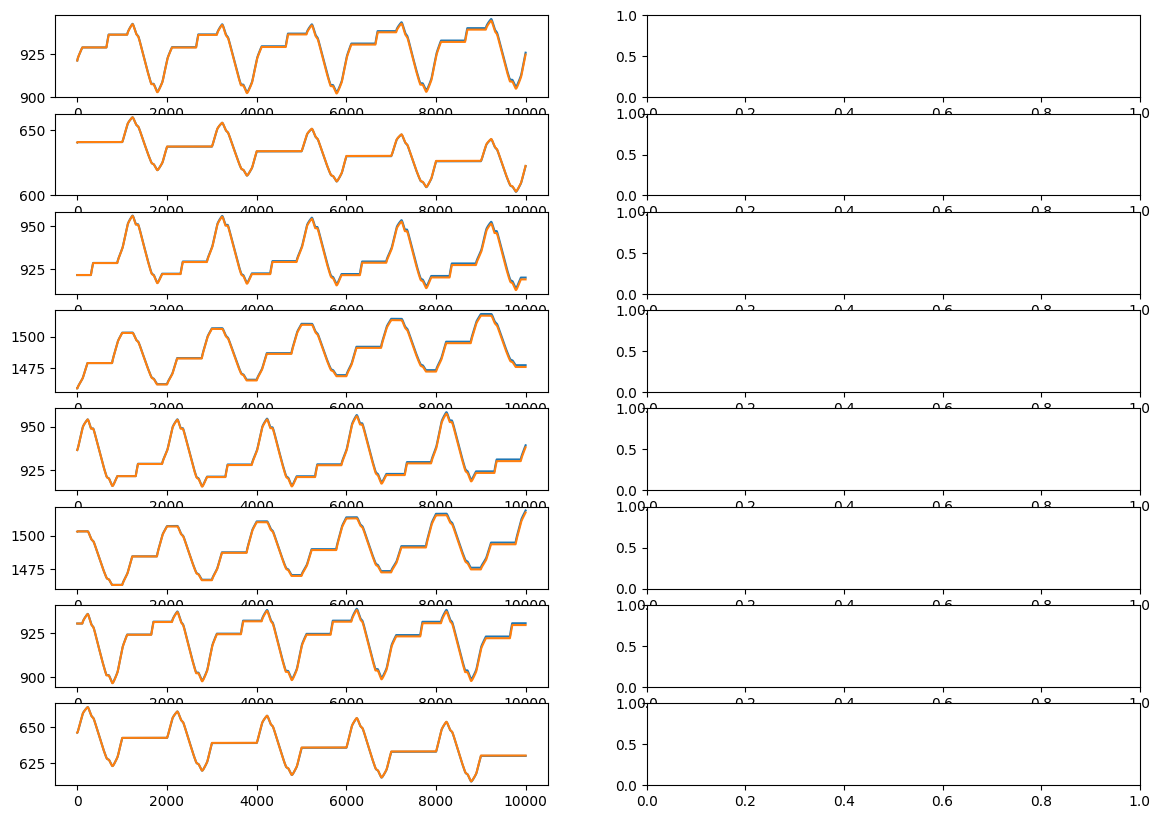

In [18]:
fig, ax = plt.subplots(8,2, figsize=(14,10))
for i in range(8):
    ax[i,0].plot(Vc_synthetic[:,i])
    ax[i,0].plot(Vc_all[:,i])
# plt.tight_layout()

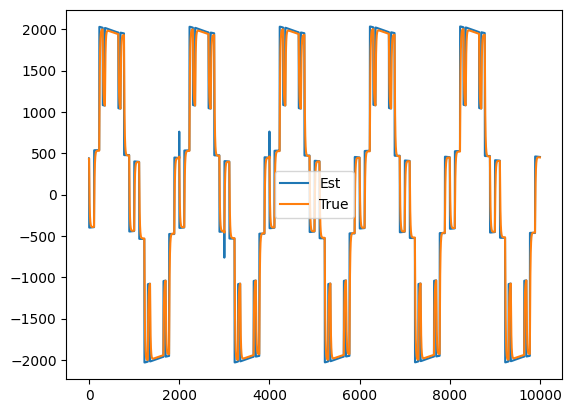

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(np.array(Vth_synthetic).flatten(), label="Est")
ax.plot(y.flatten(), label="True")
ax.legend()